In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import symbol as s
import seaborn as sns
from sklearn.preprocessing import scale

sns.set_style("dark")

%matplotlib inline

In [2]:
symbol = s.Symbol(index='nifty_500', start=2015, null_count=5)
index = s.Index(index_list='nifty_50', start=2015)

In [3]:
ret = symbol.get_symbol_returns(end=2016).drop('swanenergy', axis=1)
ret = ret.interpolate(method='time', limit=5, limit_direction='backward')
corr_mat = ret.corr()
idata = index.get_index_hist()
iret = index.get_index_returns()
beta = symbol.calculate_capm(returns=ret, benchmark_returns=iret)
beta = beta.set_index('symbol')
ret_describe = symbol.describe_returns(ret)
ret_describe = ret_describe.join(beta.drop(['std_dev'], axis=1))
len(ret), len(ret.columns), len(idata), len(iret), len(beta)

(249, 475, 485, 485, 475)

In [4]:
condition = (ret_describe.total_returns > 0) & (ret_describe.pos_pctile > 0) & \
    (ret_describe.beta > 0) & (ret_describe.sharpe_ratio > 0.1) & (ret_describe.median_returns > 0)
ret_describe = ret_describe[condition].sort_values('std_dev')
corr_mat = ret[ret_describe.index].corr()
ret_describe.head()

,num_returns,mean_returns,std_dev,min_returns,max_returns,total_returns,median_returns,pos_pctile,sharpe_ratio,25_pctile,50_pctile,75_pctile,benchmark,alpha,beta,r_square,p_value,std_error
symbol,,,,,,,,,,,,,,,,,,
tnpl,249,0.0028,0.0223,-0.1152,0.0840,0.7018,0.0010,0.5100,0.1135,-0.0111,0.0010,0.0154,nifty_50,0.003032,1.124852,0.265400,2.791160e-18,0.119075
aartiind,249,0.0029,0.0255,-0.0874,0.0891,0.7336,0.0014,0.5341,0.1043,-0.0120,0.0014,0.0153,nifty_50,0.003039,0.855572,0.117561,2.817303e-08,0.149148
kprmill,249,0.0036,0.0257,-0.1557,0.0903,0.8915,0.0011,0.5181,0.1282,-0.0096,0.0011,0.0153,nifty_50,0.003856,1.264179,0.252558,2.430760e-17,0.138378
gayaproj,249,0.0061,0.0313,-0.1216,0.1329,1.5272,0.0003,0.5060,0.1869,-0.0127,0.0003,0.0203,nifty_50,0.006450,1.355200,0.195818,2.309921e-13,0.174745
navinfluor,249,0.0047,0.0313,-0.1755,0.1784,1.1581,0.0031,0.5622,0.1395,-0.0124,0.0031,0.0181,nifty_50,0.004821,1.025630,0.112152,6.126745e-08,0.183615


In [5]:
req_sym = (ret_describe.total_returns*ret_describe.median_returns).sort_values(ascending=False).index
req_ret = ret[req_sym]
somesym = req_ret.ix[:, 0:20].corr().mean().sort_values().head(5).index
req_ret = ret[somesym]
req_ret.head()

symbol,jmtautoltd,aartiind,8kmiles,caplipoint,rajeshexpo
date,,,,,
2015-01-01,-0.000469,0.020024,0.143937,-0.003596,0.041637
2015-01-02,0.016752,0.008901,0.104790,0.005946,0.006048
2015-01-05,-0.013005,-0.015336,-0.039654,0.013494,0.010000
2015-01-06,-0.021262,-0.009829,0.055744,-0.040152,-0.062264
2015-01-07,-0.030056,-0.020961,0.002981,0.016355,-0.000706


In [ ]:
mys = 'coromandel'
req_sym = corr_mat[mys].sort_values().head(10).index.tolist()
req_sym.append(mys)
req_ret = ret[req_sym]

In [6]:
def calculate_variance(returns, weights=None):
    if isinstance(returns, pd.Series):
        returns = pd.DataFrame(returns)
        return calculate_variance(returns, weights=weights)
    if weights is None: 
        weights = np.ones(returns.columns.size) / \
        returns.columns.size
    if isinstance(weights, list):
        weights = np.array(weights)
    sigma = np.cov(returns.T,ddof=0)
    var = (weights * sigma * weights.T).sum()
    return var
def sharpe_ratio(returns, weights = None, risk_free_rate = 0.075):
    if isinstance(returns, pd.Series):
        returns = pd.DataFrame(returns)
        return sharpe_ratio(returns, risk_free_rate=risk_free_rate)
    n = returns.columns.size
    if weights is None: weights = np.ones(n)/n
    # get the portfolio variance
    var = abs(calculate_variance(returns, weights))
    # and the means of the stocks in the portfolio
    means = returns.mean()
    # and return the sharpe ratio
    risk_free_rate = np.log(1+risk_free_rate)/252
    sharpe = (means.dot(weights) - risk_free_rate)/np.sqrt(var)
    return sharpe
import random

def constrained_sum_sample_pos(n, total):
    """Return a randomly chosen list of n positive integers summing to total.
    Each such list is equally likely to occur."""

    dividers = sorted(random.sample(range(1, total), n - 1))
    return [a - b - 1 for a, b in zip(dividers + [total], [0] + dividers)]
sharpe_ratio(req_ret)

0.23369113983508707

In [7]:
sh_w = []
def helsf(returns):
    max_sh = -np.inf
    i = 0
    n = returns.columns.size
#     weights = [0 for p in range(n)]
    while i < 10000:
        weights =(constrained_sum_sample_pos(n, 20 + n))
        if weights not in sh_w:
            sh_w.append((weights))
        else:
            i = i+0.5
            continue
        weights = np.array(weights)/np.array(weights).sum()
        sharpe_rat = sharpe_ratio(returns, weights)
        if sharpe_rat > max_sh:
            max_i = i
            max_sh = sharpe_rat
            max_weights = weights
        i = i+1
    return max_i, max_sh, max_weights
helsf(req_ret)

(3826.0, 0.23580919756649557, array([ 0.2 ,  0.2 ,  0.2 ,  0.15,  0.25]))

In [95]:
0.092087104085610494,
 array([ 0.1,  0. ,  0.1,  0.1,  0.2,  0. ,  0. ,  0. ,  0. ,  0.2,  0.3]))

IndentationError: unexpected indent (<ipython-input-95-d00f97ee02c8>, line 2)

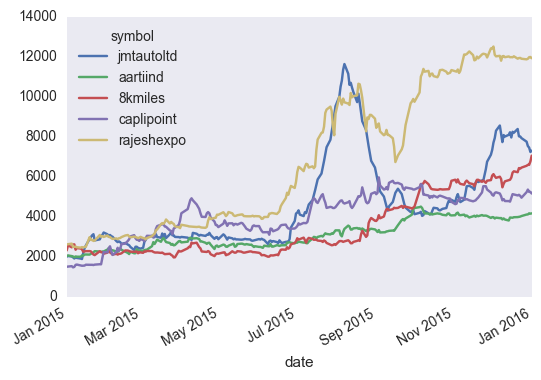

In [177]:
port = s.Portifolio()
my_port = port.create_portifolio(ret=req_ret, weights=[ 0.2 ,  0.2 ,  0.2 ,  0.15,  0.25])
my_port.drop('value', axis=1).plot()

In [178]:
my_port.value.std(), my_port.value.min(), my_port.value.max(), my_port.value.tail(1)

(8376.586067775454, 10320.102416432193, 35678.086314067987, date
 2016-01-01    35590.172701
 Name: value, dtype: float64)

In [ ]:
(2866.190746983067, 8913.3170924669867, 17915.715308708779)

date
2016-01-01    10062.219968
2016-01-04    10080.652261
2016-01-05    10165.734398
2016-01-06    10116.613790
2016-01-07    10029.652848
2016-01-08    10084.436415
2016-01-11    10057.649503
2016-01-12     9842.914962
2016-01-13     9984.365537
2016-01-14     9847.839284
2016-01-15     9516.643244
2016-01-18     8961.395587
2016-01-19     9085.871245
2016-01-20     8866.366951
2016-01-21     8947.334479
2016-01-22     9305.569903
2016-01-25     9574.443347
2016-01-27     9645.585716
2016-01-28     9604.194273
2016-01-29     9671.686256
2016-02-01     9660.583332
2016-02-02     9489.261518
2016-02-03     9154.266415
2016-02-04     9285.294482
2016-02-05     9259.901043
2016-02-08     9309.781986
2016-02-09     9091.685127
2016-02-10     8826.499123
2016-02-11     8224.500983
2016-02-12     8014.847714
                  ...     
2016-11-09     9475.221642
2016-11-10     9728.893554
2016-11-11     9318.451171
2016-11-15     8973.606301
2016-11-16     9071.254004
2016-11-17     9044.450

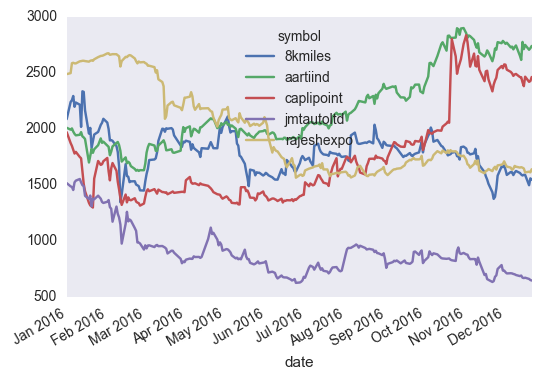

In [179]:
new_ret = symbol.get_symbol_returns(symbol_list=req_ret.columns.tolist(), start=2016)
my_port = port.create_portifolio(ret=new_ret, weights=[ 0.2 ,  0.2 ,  0.2 ,  0.15,  0.25])
my_port.drop('value', axis=1).plot()
my_port.value

In [ ]:
def trend(returns):
    profit = (ret > 0).astype(int).replace(0, -1)
    t=0
    trend_series = pd.Series(name=profit.name)
    for i in enumerate(profit):
        if (dres[i[0]] * dres[i[0]-1]) > 0:
            p = p + profit[i[0]]
        else:
            p=profit[i[0]]
        trend_series[profit.index[i[0]]] = p
    return trend_series
trend = ret.apply(soma)

In [ ]:
smas = ['mean_returns', 'std_dev', 'min_returns', 'max_returns', 'total_returns', 'median_returns']
sdf = pd.DataFrame(index=smas, columns=smas)
sdf.ix['mean_returns', :] = [1, 5, 3, 2, 3, 4]
sdf.ix['std_dev', :] = [0.2, 1, 2, 1, 3, 4]